In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib.font_manager as font_manager
from matplotlib.ticker import MultipleLocator
import scipy.fftpack as fftpack
import os
%matplotlib inline

In [2]:
def rebin(freq, power, rebin_const=1.04):

    ## Initialize variables
    rb_power = np.asarray([])  # List of re-binned power
    rb_freq = np.asarray([])   # List of re-binned frequencies
    real_index = 1.0		   # The unrounded next index in power
    int_index = 1			   # The int of real_index, added to current_m every iteration
    current_m = 1			   # Current index in power
    prev_m = 0				   # Previous index m
    bin_power = 0.0			   # The power of the current re-binned bin
    bin_freq = 0.0			   # The frequency of the current re-binned bin
    bin_range = 0.0			   # The range of un-binned bins covered by this re-binned bin

    ## Loop through the length of the array power, new bin by new bin, to
    ## compute the average power and frequency of that new geometric bin.
    ## Equations for frequency, power, and error are from A. Ingram's PhD thesis
    while current_m < len(power):

        ## Determine the range of indices this specific geometric bin covers
        bin_range = np.absolute(current_m - prev_m)
        ## Want mean power of data points contained within one geometric bin
        bin_power = np.mean(power[prev_m:current_m])

        ## Compute the mean frequency of a geometric bin
        bin_freq = np.mean(freq[prev_m:current_m])

        ## Append values to arrays
        rb_power = np.append(rb_power, bin_power)
        rb_freq = np.append(rb_freq, bin_freq)
        
        ## Increment for the next iteration of the loop
        ## Since the for-loop goes from prev_m to current_m-1 (since that's how
        ## the range function and array slicing works) it's ok that we set
        ## prev_m = current_m here for the next round. This will not cause any
        ## double-counting bins or skipping bins.
        prev_m = current_m
        real_index *= rebin_const
        int_index = int(round(real_index))
        current_m += int_index
        bin_range = None
        bin_freq = None
        bin_power = None

    return rb_freq, rb_power

In [3]:
# ccf_file_1 = os.getcwd()+"/out_ccf/GX339-4HzCQPO/GX339-4HzCQPO_170418_t64_64sec_timeoffset_filt_adj.fits"
ccf_file_1 = os.getcwd()+"/out_ccf/GX339-4HzCQPO/GX339-4HzCQPO_170425_t64_64sec_nooffset_filt_adj.fits"
ccf_1 = Table.read(ccf_file_1)
ccf_file_2 = os.getcwd()+"/out_ccf/GX339-4HzCQPO/GX339-4HzCQPO_170502_t64_64sec_filt_adj.fits"
ccf_2 = Table.read(ccf_file_2)
# ccf_file_3 = os.getcwd()+"/out_ccf/GX339-4HzCQPO/GX339-4HzCQPO_170419_t64_64sec_phaseoffset_filt_adj.fits"
# ccf_3 = Table.read(ccf_file_3)


n_bins = ccf_1.meta['N_BINS']
# print ccf_1.info
# print ccf_1.meta
ccf_1.meta['RATE_CI'] = np.asarray(ccf_1.meta['RATE_CI'][1:-1].split(', '), dtype=np.float64)
ccf_2.meta['RATE_CI'] = np.asarray(ccf_2.meta['RATE_CI'][1:-1].split(', '), dtype=np.float64)
# ccf_3.meta['RATE_CI'] = np.asarray(ccf_3.meta['RATE_CI'][1:-1].split(', '), dtype=np.float64)

In [5]:
power_1 = np.sqrt(fftpack.fft(np.asarray(ccf_1['CCF'][:,4], dtype=float))**2)
power_1 = np.abs(power_1[0:n_bins/2+1])
# print len(power_1)
power_2 = np.sqrt(fftpack.fft(np.asarray(ccf_2['CCF'][:,4], dtype=float))**2)
power_2 = power_2[0:n_bins/2+1].real
# print len(power_2)
# power_3 = np.sqrt(fftpack.fft(np.asarray(ccf_3['CCF'][:,4], dtype=float))**2)
# power_3 = power_3[0:n_bins/2+1].real
# print len(power_3)

freq = np.arange(0, ccf_1.meta['DF']*4097, ccf_1.meta['DF'])

In [6]:
rb_freq1, rb_power_1 = rebin(freq, power_1, rebin_const=1.03)
npn_1 = rb_power_1 * rb_freq1
rb_freq2, rb_power_2 = rebin(freq, power_2, rebin_const=1.02)
npn_2 = rb_power_2 * rb_freq2
# rb_freq3, rb_power_3 = rebin(freq, power_3, rebin_const=1.03)
# npn_3 = rb_power_3 * rb_freq3

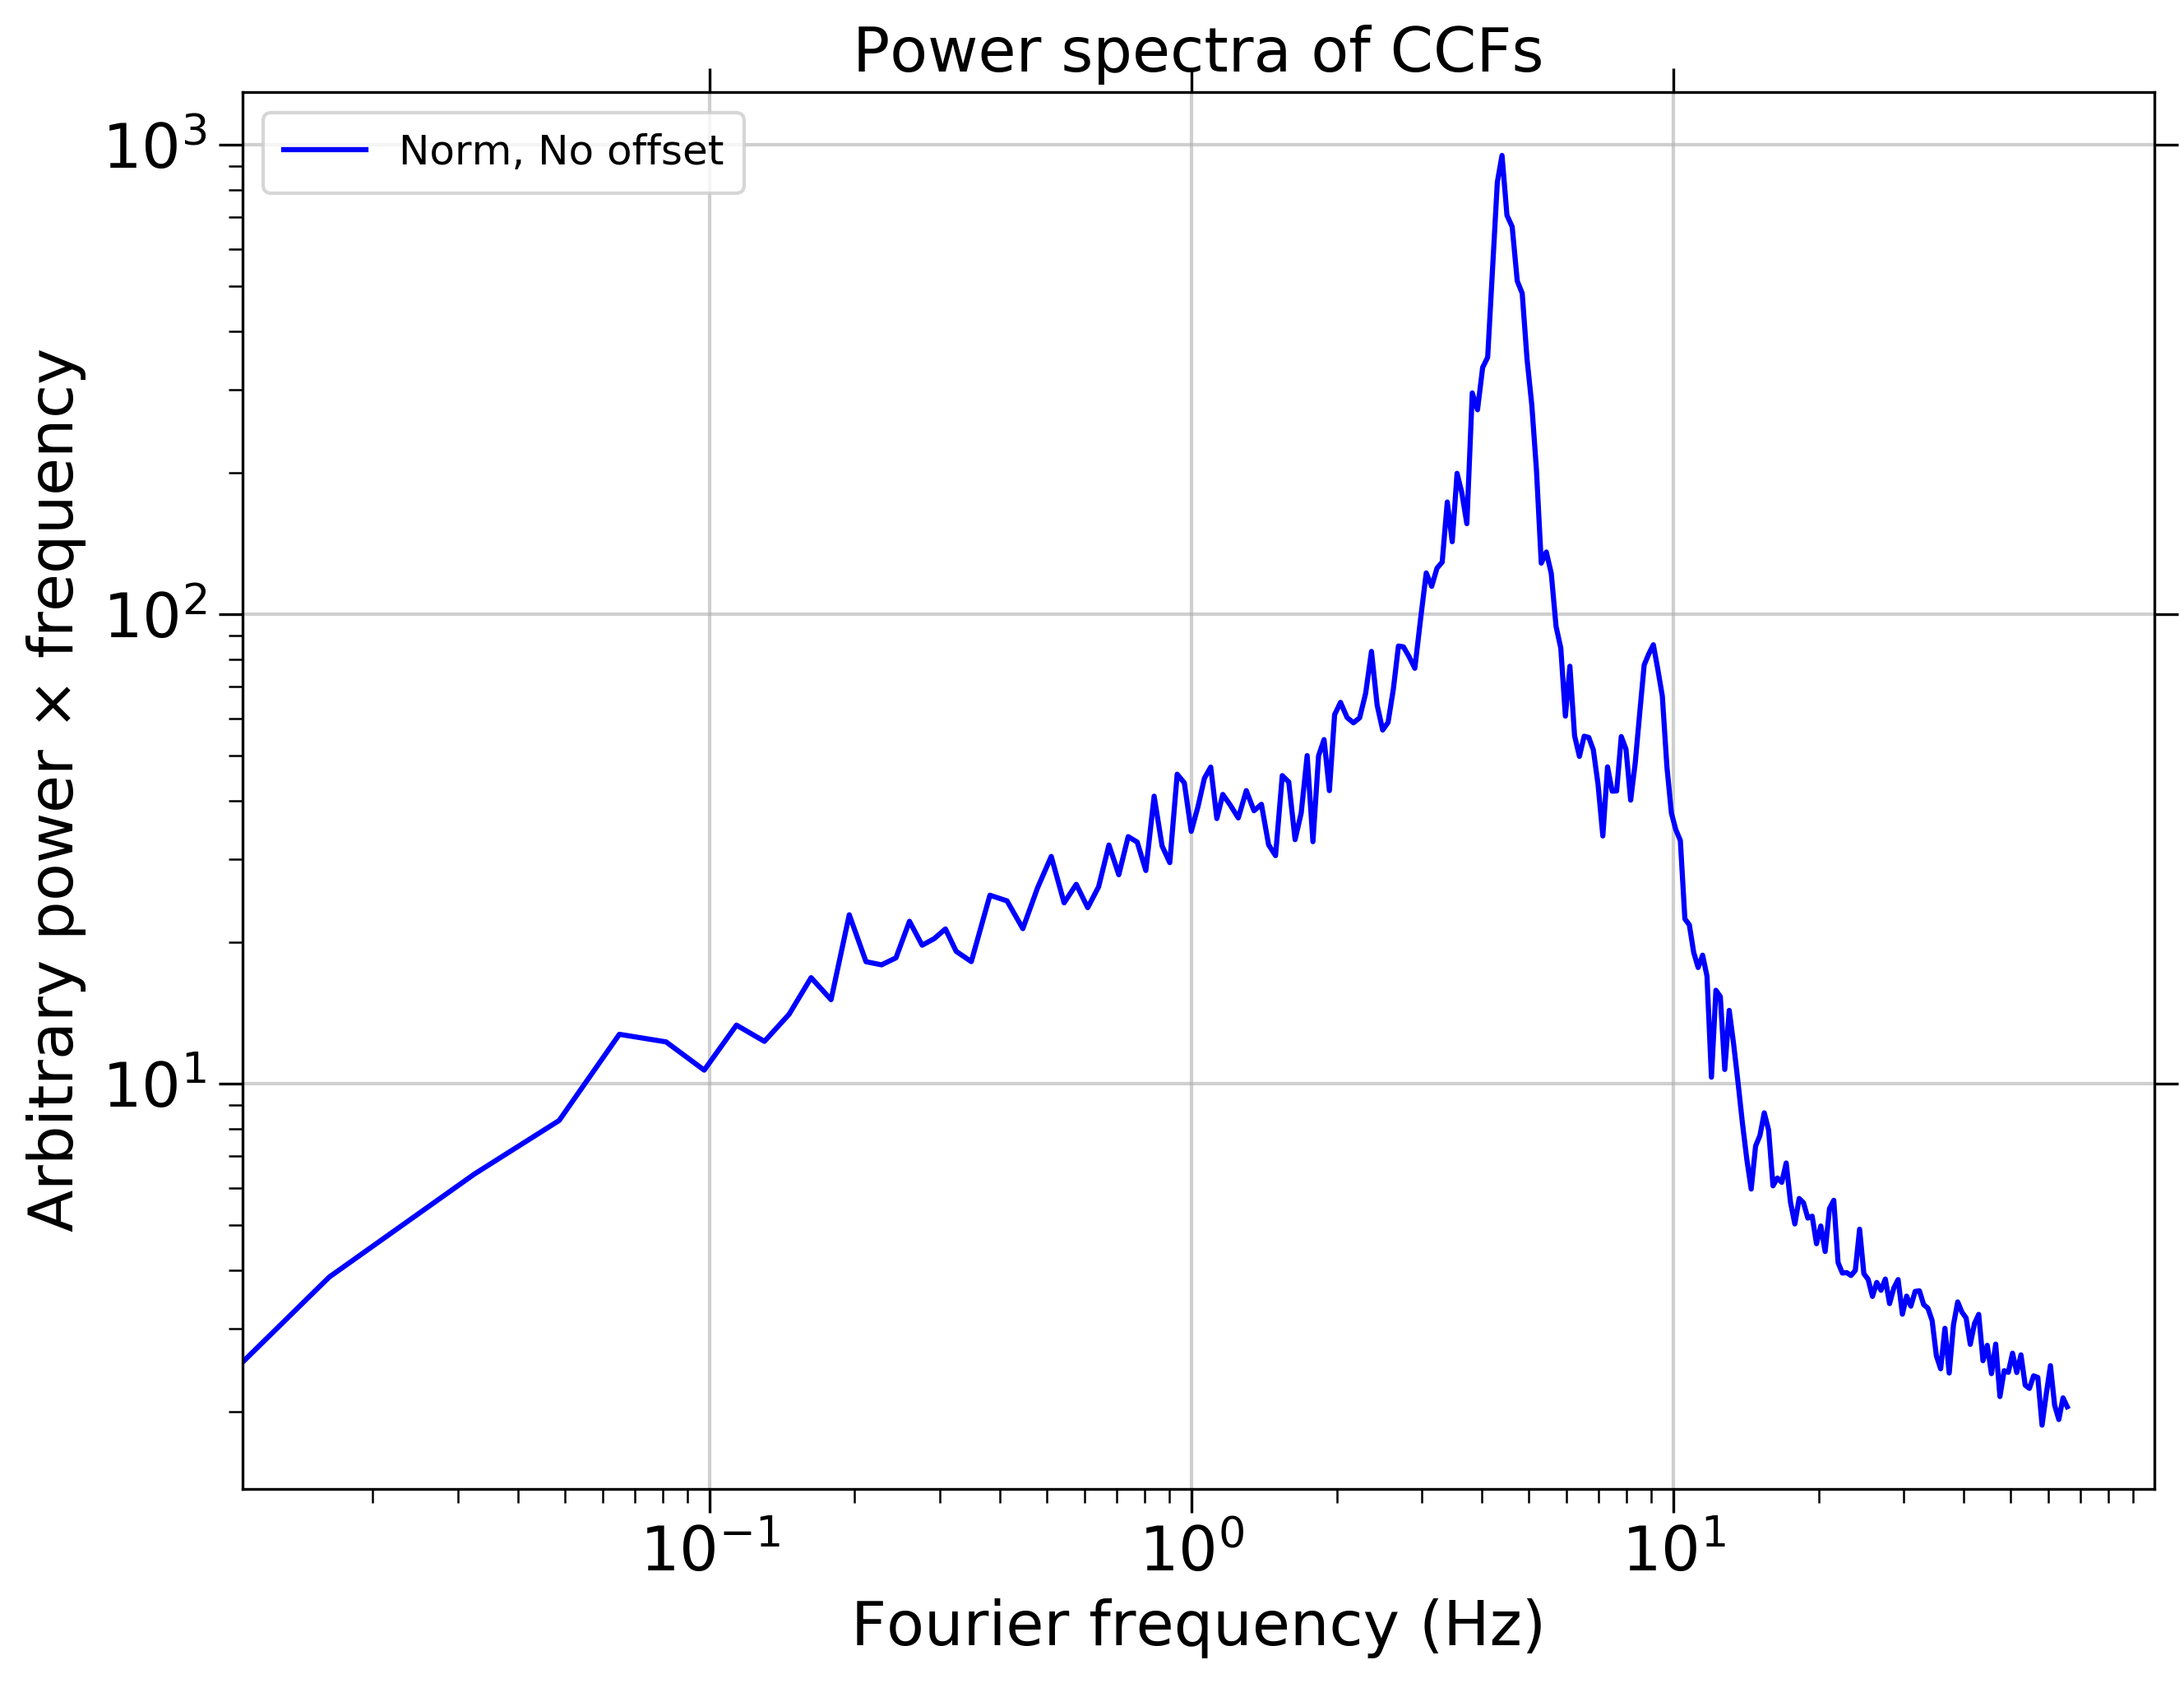

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7.5), dpi=300)
# ax.plot(rb_freq1, npn_1, color='red', label="No norm, no offset")
ax.plot(rb_freq2, npn_2, color='blue', label="Norm, No offset")
# ax.plot(rb_freq3, npn_3, color='green', lw=2, label="Phase offset")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Fourier frequency (Hz)", fontsize=18)
ax.set_ylabel(r"Arbitrary power $\times$ frequency", fontsize=18)
ax.set_title("Power spectra of CCFs", fontsize=18)
# ax.set_ylim(1e-5, 1e7)
ax.grid(True, which='major', lw=1, alpha=0.6)
ax.tick_params(axis='x', labelsize=18, bottom=True, top=True, \
    labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=18, left=True, right=True, \
    labelleft=True, labelright=False)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)
# for axis in ['top', 'bottom', 'left', 'right']:
#     ax.spines[axis].set_linewidth(2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=12,
            borderpad=0.5, labelspacing=0.5, borderaxespad=0.5)
# plt.savefig("psd_of_unnorm_ccf.png")
plt.show()

In [25]:
print np.max(npn_1)
print np.argmax(npn_1)
print np.max(npn_1[80:])
print np.argmax(npn_1[80:])+80
print np.max(npn_1) / np.max(npn_1[80:])

1224350816.23
75
116530365.675
97
10.5067104967
